In [139]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import folium
from twarc import Twarc
from geotext import GeoText
from textblob import TextBlob
from bs4 import BeautifulSoup
import requests
import pycountry
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from stop_words import get_stop_words
from gensim import corpora, models
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
%pylab inline
import re
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


C:\Users\arsal\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


<h1>1. Data Collection</h1>

<h2>1a) Collecting Trump tweets</h2>

We utilised the several datasets available at https://github.com/bpb27/trump_tweet_data_archive which happen to be automatically updated every hour. All of the datasets are saved in json format and the data contained in them is the result of calls to the Twitter API. There are two varients, <b>master</b> which contains all of the original information from the API call and <b>condensed</b> which contains a lot less but essential information. After looking through some of the master and condensed datasets, we decided that the condensed datasets were sufficient as they contained the specfic fields we required and the entries in master were unnecessarily large for our purpose (too much information that we would not use). <br>

We're using all of the condensed datasets from 2009 to 2017 because the tweet data isn't that time consuming to process and having as much data as possible will be beneficial when clustering the messages in the tweets. Since the 2017 datatset is continiously being updated, we are only using it up to a certain date. All of the data in total is around 10 MB so it is really simple to handle and there is no need to rely on additional computing resources<br>

Below, we iterate over each json file and turn them into a pandas DataFrame and store them in the list <b>data</b>. We do this so that later on we can simply combine them into one single dataframe.

In [140]:
#Create empty list to store all of our data
data=[]

#Add data from 2009 to 2017, 2017 data obtained 28/11/2017
data.append(pd.DataFrame(json.load(open("data/condensed_2009.json"))))
for i in range(10,18):
    fileName="data/condensed_20"+str(i)+".json"
    data.append(pd.DataFrame(json.load(open(fileName))))

Next, we combine all of our seperate datasets into one pandas dataframe. We also set the id of the dataframe to <b>id_str</b> since we already know that each of the ids are unique. we also have to convert the <b>created_at</b> attribute into a Date object so that the dataframe is able to properly sort tweets by date (if it was still a string then it would sort incorrectly as it would put tweets starting on a Friday first).

In [141]:
#Combine all of the individual datasets together
df = pd.concat(data)

#Set the index
df = df.set_index("id_str")

#Convert to Date
df["created_at"]=pd.to_datetime(df["created_at"])

In [142]:
df.sort_values("created_at",inplace=True)
df.head()

,created_at,favorite_count,in_reply_to_user_id_str,is_retweet,retweet_count,source,text
id_str,,,,,,,
1698308935,2009-05-04 18:54:25,202,None,False,253,Twitter Web Client,Be sure to tune in and watch Donald Trump on L...
1701461182,2009-05-05 01:00:10,3,None,False,2,Twitter Web Client,Donald Trump will be appearing on The View tom...
1737479987,2009-05-08 13:38:08,2,None,False,3,Twitter Web Client,Donald Trump reads Top Ten Financial Tips on L...
1741160716,2009-05-08 20:40:15,27,None,False,8,Twitter Web Client,New Blog Post: Celebrity Apprentice Finale and...
1773561338,2009-05-12 14:07:28,1950,None,False,1421,Twitter Web Client,"""My persona will never be that of a wallflower..."


<h2>1b) Reply tweets data</h2>

In order to do a sentiment analysis, we need to create a dataframe containing replies to Trump's tweets. To do this, we use the library Twarc which simplifies the API call process. Note that due to a limitation in the Twitter API, getting replies to a tweet is not a feature by default so you have to use a workaround. One thing that's commonly done is to use Twitter's search function, it would involve searching for all messages directed at Trump and then seeing which ones have a reply_id (the id of the tweet they are replying to) that is equal to a given Trump tweet id. The problem with this is that it is only able to look for replies to tweets that are max a week old. The second issue is that the amount of times that you can use the search function in the Twitter API is limited to a 100 queries an hour which is not ideal since it would take too long to get enough tweets to train our classifiers.

Instead, we decided to do the following. We iterate over all of Trump's tweets, get the id of these tweets and then do a http request to the twitter page containing that tweet. Then we parse the page using BeautifulSoup and search for the attribute "data-tweet-id" in the HTML text. This attribute corresponds to an id of any tweet on that page which means that we can easily obtain the id of replies. Then, instead of using the search function in the Twitter API, we use a different method that can lookup tweet information given an id. This method is not limited to tweets that are more than 7 days old and has a higher rate limit. 

We are using the package Twarc and to use it we need authenticate it with keys and access tokens that can be obtained from the Twitter Dev website.

The keys won't be available in GitHub for security reasons, instead we read them from a local file. The format is one line where
each key is seperated by a ":"

In [143]:
fname="data/authKeys.txt"
f = open(fname, "r")

keys=f.read()[2:].split(":")

for i in keys:
    i=i.replace("\x00","")

t = Twarc(keys[0],keys[1],keys[2],keys[3])

Below, we are building a dataframe to store the reply texts as well as other information we might find useful. Since the webscraping process takes time, we felt that it was better to prioritize the latest 2000 tweets as they are more relevant than tweets that were made before Trump's presidency. 

In [144]:
#A list of lists for creating the 2D dataframe
L=[]

#Column names for our dataframe containing replies
indexList=["reply_id","trump_id","created_at","coordinates","favorite_count","retweet_count","geo",
                              "place","full_text","location","time_zone","utc_offset"]

#Add a list for each feature
for i in range(len(indexList)):
    L.append([])

#Create empty dataframe
replyDf=pd.DataFrame(columns=indexList)

#Sort trump dataframe to get recent first
df.sort_values("created_at",inplace=True,ascending=False)

#Adds the information from the reply tweet into our list of lists L
def CreateReplyEntry(trumpId,replyId,replyTweet):
    L[0].append(replyId)
    L[1].append(trumpId)
    for i in range(len(indexList)):
        if(i>1):
            if(i>8): #This if exists because of how the Json string replyTweet is formed
                L[i].append(replyTweet["user"][indexList[i]])
            else:
                L[i].append(replyTweet[indexList[i]])

'''
For every tweet in given range (start,end), this finds several replies
to that tweet (not guaranteed to find all replies)
start and end are indexes in trump tweets dataframe
'''
def ScrapeReplies(start,end):
    #Iterate over every tweet
    for i in range(start,end):
        if(i%100==0):
            print("Tweet: "+str(i))

        #Get trump tweet and id
        tweet=df.iloc[i]
        tweetId=df.index[i]

        url="https://twitter.com/realDonaldTrump/status/"+tweetId
        r = requests.get(url)
        soup = BeautifulSoup(r.text, 'html.parser')

        #Finds all div tags and if it has the corresponding id, add that id to a list
        soup.find_all("div")
        divs = soup.find_all("div")
        ids=[]
        for d in divs:
            if d.has_attr('data-tweet-id'):
                ids.append(d["data-tweet-id"])  

        '''
        ids is a list of all tweets on the url, we want to 
        ignore Trump's tweet id and only do a lookup for the replies        
        '''
        for i in ids:
            if(i!=tweetId): #ignore trump tweet id
                reply=t.tweet(i)
                CreateReplyEntry(tweetId,i,reply)   

    #Fills the dataframe with information stored in L
    for i in range(len(indexList)):
        replyDf[indexList[i]]=L[i]

    #Write dataframe to local file
    replyDf.to_pickle("data/replies/replies_"+str(start)+"_"+str(end)+".pkl")
    print("replies for tweets "+str(start)+" to "+str(end)+" saved")

#Use line below to scrape replies (can take 1 to 2 hours to complete)
#ScrapeReplies(0,2000) 

<h1>2. Analyzing the data</h1><br>

<h2>2a) Attributes in the condensed Trump data</h2>

What does the data look like ? In each json file, there is an array where each element represents
a seperate tweet. In each array element, the following information can be found:<br>

<ul>
<li><b>created_at:</b> (string) the date the tweet was posted<br></li>
<li><b>favourite_count:</b> (integer) represents the number of individual users that liked this post<br></li>
<li><b>id_str:</b> (string) a unique string id for this tweet provided by the API<br></li>
<li><b>in_reply_to_user_id_str:</b> (string) the string id of a tweet that this tweet is a reply to<br></li>
<li><b>is_retweet:</b> (boolean) True if this tweet is a retweet of another tweet <br></li>
<li><b>retweet_count:</b> (integer) an integer representing the amount of times this tweet was retweeted<br></li>
<li><b>source:</b> (string/categorical) the type of device this tweet was posted from (for example a desktop or phone)<br></li>
<li><b>text:</b> (string) the actual text from this tweet<br></li>
</ul>


To see all of the possible values of <b>source</b>, we simply use the following line:

In [145]:
df["source"].unique()

array(['Twitter for iPhone', 'Twitter for iPad', 'Media Studio',
       'Twitter Web Client', 'Twitter Ads', 'Twitter for Android',
       'Periscope', 'TweetDeck', 'Instagram', 'Mobile Web (M5)',
       'Twitter Mirror for iPad', 'Twitter QandA', 'Facebook',
       'Twitter for BlackBerry', 'Neatly For BlackBerry 10',
       'Twitter for Websites', 'Twitlonger', 'Vine - Make a Scene',
       'TwitLonger Beta'], dtype=object)

<b>favourite_count</b> and <b>retweet_count</b> are both positive integers

Below is an example of what 1 entry may look like

In [146]:
df.iloc[0]

created_at                                     2017-11-28 02:50:30
favorite_count                                               25703
in_reply_to_user_id_str                                       None
is_retweet                                                   False
retweet_count                                                 6307
source                                          Twitter for iPhone
text                       Thank you Rand! https://t.co/NvPeleVmub
Name: 935340092583006208, dtype: object

One important thing to be noted about twitter for those who are unfamiliar, a retweet is essentially where you take someone else's tweet and post that to your twitter feed where as a reply is a tweet that is directly aimed at an existing tweet. 

What we can see from the dataset above is that not all of the information we need is there. For example to do a proper sentiment analysis of people reacting to Trump, we need to look at the replies of these people. Also, we need to see what country those replies originated from. This can be done using the twitter API since the API calls contain more extensive information such as geolocation of the tweet's origin. 

If we take a look at the tweets themselves, we see that there are certain symbols and text that we can remove as they don't contribute to our clustering of topics. For example, a lot of tweets contain external http links. Also, twitter happens to encode the & symbol as the string &amp so these need to be converted. 


<h2>2b) Computing statistical information</h2>

Using the describe function below, we can see that there are 30192 tweets in our total dataset. Only two of the features can have these values computed because the rest are strings or booleans. 

In [147]:
df.describe()

,favorite_count,retweet_count
count,32547.000000,32547.000000
mean,8458.899315,2582.873383
std,25235.173044,7438.815940
min,0.000000,0.000000
25%,20.000000,16.000000
50%,68.000000,107.000000
75%,1922.000000,1157.000000
max,633253.000000,369530.000000


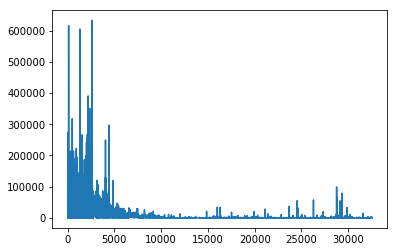

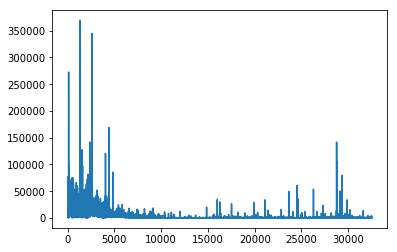

In [148]:
plt.plot(list(df["favorite_count"]))
plt.show()
plt.plot(list(df["retweet_count"]))
plt.show()

<h2>2c) Checking for missing values</h2>

We will now check to see if there are potentially any values missing at all. Note that we don't consider a value of None in <b>in_reply_to_user_id_str</b> to be a missing value as it's acceptable for a tweet to not reply to another. We make a copy of our original dataframe, drop the in_reply_to_user_id_str (because pandas replcae the value None with a null value in this case) and then do a query to return all entries with some form of missing value. As we can see, we get no entries in this case so all of the values are present.

In [149]:
dfNull=df.copy()
dfNull=dfNull.drop("in_reply_to_user_id_str",axis=1)
dfNull[dfNull.isnull().any(axis=1)]

,created_at,favorite_count,is_retweet,retweet_count,source,text
id_str,,,,,,


<h2>2d) Correlations between features</h2>

Next we want to analyze the correlations between the different fields. It doesn't make sense to look at correlations between string fields and the rest as the strings can take on a large range of values that aren't repeated often. However we can convert the categorical strings into integers as they occur frequently. We create a copy of the dataframe and then create a dictionary to have a mapping from a <b>source</b> value to an integer. Then we alter all of the rows in this datafram to have these integer values.

In [150]:
dfCorr=df.copy()

keys=dfCorr["source"].unique()
values=list(range(len(keys)))
dictionary = dict(zip(keys, values))

for i in range(len(dfCorr)):    
    s=dfCorr.iloc[i]["source"]
    dfCorr.iloc[i, dfCorr.columns.get_loc('source')] = int(dictionary.get(s))
    
dfCorr["source"] = dfCorr["source"].astype('int64')

In [151]:
dfCorr.dtypes

created_at                 datetime64[ns]
favorite_count                      int64
in_reply_to_user_id_str            object
is_retweet                           bool
retweet_count                       int64
source                              int64
text                               object
dtype: object

Below is a correlation matrix between all of the integer values as well as 

In [152]:
corrMatr=dfCorr.corr(method='pearson', min_periods=1)
corrMatr

,favorite_count,is_retweet,retweet_count,source
favorite_count,1.000000,-0.040312,0.903915,-0.281563
is_retweet,-0.040312,1.000000,0.100370,-0.170955
retweet_count,0.903915,0.100370,1.000000,-0.275444
source,-0.281563,-0.170955,-0.275444,1.000000


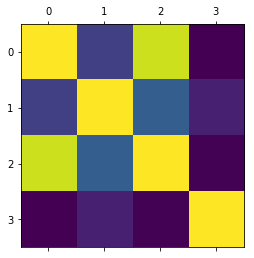

In [153]:
plt.matshow(corrMatr)
plt.show()

To interpret the matrix, yellow is for 100% correlation (when a variable correlates to itself), the more darker colours represent less correlation and the green one show that there is a relatively high correlation (>90%). What we see is that for Trump's tweets, the <b>favorite_count</b> and <b>retweet_count</b> are highly correlated. The correlations between the other variables are quite low (from -0.021752 to 0.134390)

In [154]:
replies=pd.read_pickle("data/replies/replies_0_2000.pkl")

<h2>Analyzing the replies data</h2>

The main challenge with the replies dataset we created is that not all of the features we need may be present as well as the fact that user's seem to have full control over what their locations can be. This is illustrated below:

In [155]:
def CountNotNull(r):
    notNone=0
    for i in r.values:
        if(not i==None)&(not i==""):
            notNone+=1
    print(str(round(notNone/len(r.values)*100,4))+"% are not null")
    
CountNotNull(replies["coordinates"])
CountNotNull(replies["geo"])
CountNotNull(replies["place"])
CountNotNull(replies["location"])
CountNotNull(replies["time_zone"])
CountNotNull(replies["utc_offset"])

0.0973% are not null
0.0973% are not null
2.2024% are not null
70.2924% are not null
49.2094% are not null
100.0% are not null


We see that using coordinates, geo or place field is not sufficient as a lot of the values are missing. time_zone has 51% of values missing and even if the existing values where used, they are not precise enough as several countries can share the same time_zone. utc_offset share the same problem as time_zone and is only useful if it were used to verify a location (for example if the location is Las Vegas but the UTC offset is 0 (same time zone as London) then we know the location is incorrect. So we decided to rely on using the location field

The problem with the location field is that users are able to enter any string as their location. This causes the following issues:

<ul>
<li><b>Multiple strings referring to the same location:</b> The strings "USA", "America", "United States" for example all refer
to the same location, the United States. For our visualisations to work, a 2 or 3 country code or the name of the country
needs to be supplied. So one task will be to map several strings to the same location.</li>
<li><b>Strings that aren't useful locations:</b>Since user's have a choice in what their location is, some may decide to set their location to something that doesn't provide any meaningful information (such as "here"or "in my house"). Also, some users may put their location as continents such as Europe or North America and such locations are not specific enough since we want to analyze sentiments by country</li>
</ul>


In [156]:
len(replies["location"].unique())

6303

In [157]:
replies["location"].value_counts()[0:15]

                   9469
United States      1265
Washington, DC      455
USA                 411
Los Angeles, CA     404
Fort Myers, FL      370
Oakland, CA         322
Florida, USA        311
California, USA     305
Washington, USA     237
New York, USA       223
Texas, USA          210
New York, NY        180
LA & NYC            151
Global              148
Name: location, dtype: int64

It turns out that out of the 31874 reply tweets to handle, there are 6303 unique locations. This number is large enough to say that it would take too long to manually change each location to something valid. Also in the cell below we see that 4160 locations are only used once, 926 are used twice and so on. For the cases where a lot of tweets have the same location, it is easier to change as there are less cases to handle. 

In [158]:
replies["location"].value_counts().value_counts().head()

1    4160
2     926
3     410
4     238
5     109
Name: location, dtype: int64

<h1>3) Sentiment Analysis by Location</h1><br>

There are several steps that need to be performed before we can compute the sentiment's of replies by country. First of all we need to ensure that all replies have the correct location. If the location of a tweet is a city, this needs to be converted to a country (Las Vegas becomes United States). Also, several locations referring to the same place should be mapped to a single value (USA and United States are the same place) so that aggregation can work properly. There are also a lot of locations that are part of a sentence (for example, "Somewhere in Kansas") so the locations need to be extracted.

<h2>3a) Fixing locations for replies</h2>

In [159]:
#Load the replies
replies=pd.read_pickle("data/replies/replies_0_2000.pkl")

locations=replies["location"]
locationsNotFound=locations.value_counts()

#Dictionary that maps location to country code, needs to be filled up
locationsDict={}

def UseUsStates():
    usStates=["AL","AK","AS","AZ","AR","CA","CO","CT","DE","DC","FM","FL","GA","GU","HI","ID",
    "IL","IN","IA","KS","KY","LA","ME","MH","MD","MA","MI","MN","MS","MO","MT","NE",
    "NV","NH","NJ","NM","NY","NC","ND","MP","OH","OK","OR","PW","PA","PR","RI","SC",
    "SD","TN","TX","UT","VT","VI","VA","WA","WV","WI","WY"]

    for x in locationsNotFound.index:
        for s in x.split(","):
            if s.strip() in usStates:
                Drop(x,"US")

def ContainsUSA():
    for x in locationsNotFound.index:
        for s in x.split(","):
            if s.strip()=="USA":
                Drop(x,"US")
                
def Drop(a,b):
    locationsDict[a]=b
    try:
        locationsNotFound.drop(a,inplace=True)
    except:
        return
    
def SetUS(maxI):
    i=1
    for x in locationsNotFound.index:
        if(i>maxI):
            break
        locationsDict[x]="US"
        locationsNotFound.drop(x,inplace=True)        
        i+=1 
        
def RemoveInvalid():
    for x in locationsNotFound.index:
        if("@" in x):
            locationsDict[x]="unknown"
            locationsNotFound.drop(x,inplace=True)
        if(x==""):
            locationsDict[x]="unknown"
            locationsNotFound.drop(x,inplace=True)
            
def UseCountryMentions():
    for x in locationsNotFound.index:
        countryMentions=GeoText(x).country_mentions

        firstKey=""
        for c in countryMentions:
            firstKey=c
            break

        if(len(countryMentions)<2)&(len(countryMentions)>0):
            locationsDict[x]=firstKey
            locationsNotFound.drop(x,inplace=True)
            
def DropUnknown():
    unknown = ["A Rabbit Hole","Earth","Planet Earth","Global","Everywhere","Here","Lost City of Atlantis",
           "George Soros' basement","Here.Now","Planet Earth ","Non-Ya, Beezwax","COOL CITY","North Pole","The Resistance","Internationalist, No Pasaran","Parts Unknown",
               "Planet Earth","Over there","home","GeeksResist Headquarters","This beautiful planet","Worldwide",  "Retweeted by Matt Schlapp CPAC",   
"Somewhere beyond the sea...",
"Reality","Under your bed",  
"So far, you just can't see.",
"Always #PledgeTruth.  TrumpLuvers don't bother to follow me!  Haters will be met with a kindly block",
"Retired Aviation Pilot", 
"All Tweets Are My Own" 
              ]

    for u in unknown:
        locationsDict[u]="unknown"
        try:
            t=locationsNotFound[u]
            locationsNotFound.drop(u,inplace=True)
        except:
            b=2
            
def DropHardcoded():
    Drop("Toronto, Ontario","CA")
    Drop("UK","GB")
    Drop("Deutschland","DE")
    Drop("Ontario, Canada","CA")   
    Drop("NSW","AU")
    Drop('Trinidad and Tobago',"TT")
    Drop("Newcastle upon Tyne, United Ki","GB")
    usLoc=['Florida ',"Florida, USA",'FLORIDA','Florida, USA Earth','Florida','Palm Beach, Florida',
       'palm coast Florida',
        "Virginia, USA",
        "Virginia",
        "Richmond, VA",
        "Bethlehem, PA USA",
        "Richmond, Virginia",
        "Bethlehem, PA",
        "Commonwealth of Virginia",
        "Worcester, MA",
        "Richmond, IN",
        "Bethlehem, Pennsylvania",
        "Henrico, Virginia, USA",
        "Virginia - District 10",
        "Hampton Roads, Virginia",
        "Dundee,FL.",
        "Shenandoah Valley, Virginia",
        "Richmond, TX",
        "Richmond, CA",
        "Richmond, KY",
        "Dundee, Ohio",
        "Richmond, Virginia ",
        "Lansdowne, Pa US",
        "McLean/Virginia",
        "Warrenton, VA",
        "Loudoun County, Virginia",
        "Colorado, USA",
        "Colorado",
        "Colorado ",
        "Evergreen, Colorado",
        "Southeast Plains of Colorado",
        "eastern Colorado",
        "Georgia, USA",
        "Georgia",
        "McDonough, Georgia",
        "Georgia, USA 🇺🇸",
        "  The World.    (Georgia, USA)",
        "Palmetto, Georgia, USA",
        "Houstonian in Georgia "
              ]

    for u in usLoc:
        Drop(u,"US")

In [160]:
UseUsStates()
ContainsUSA()
DropHardcoded()
RemoveInvalid()
DropUnknown()
UseCountryMentions()
SetUS(35)

locations=replies["location"]
l=[]

a=0
for i in range(len(locations)):
    loc=locations.iloc[i]
    l.append(locationsDict.get(loc))
locs=pd.Series(l)
#locs.drop("unknown",inplace=True)
locs.value_counts().head()
replies["location"]=locs

Here we are able to see the distribution of the reply tweets

In [161]:
countryCounts=replies["location"].value_counts()
countries=[]
for x in range(len(countryCounts)):    
    countryCode=replies["location"].value_counts().index[x]
    if(countryCode!="unknown"):
        countries.append(pycountry.countries.get(alpha_2=countryCode).name)
    else:
        countries.append("unknown")
        
countryCounts.index=countries
countryCounts

United States                        14718
unknown                              10441
United Kingdom                         453
Canada                                 225
Bangladesh                             213
Australia                               78
India                                   75
Germany                                 73
Botswana                                38
China                                   32
Nigeria                                 28
Finland                                 27
Yemen                                   24
Brazil                                  23
Uruguay                                 23
Italy                                   22
Israel                                  21
France                                  19
New Zealand                             18
South Africa                            18
Egypt                                   17
Norway                                  16
Pakistan                                16
Sweden     

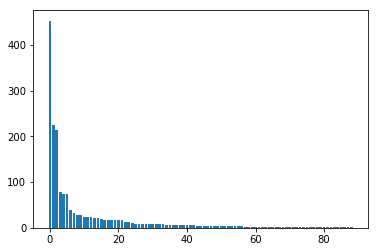

In [162]:
plt.bar(range(len(countryCounts)-2),countryCounts.values[2:])
plt.show()

In the chart above, we ignore the bars for the United States and unknown locations as it's already apparent they take a third of locations each (and the bar chart would not be very useful since their values are much larger than the rest). We can see that for the reamining countries, the distribution is not very even, most of the tweets are from United Kingdom, Canada, Bangladesh, Australia and India. There are some countries like Malaysia which only have 1 tweet representing them. Also note that out of the 195 countries in the world, only 91 are being represented.

<h2>3b) Preprocessing the tweets for sentiment analaysis</h2><br>

We want to compute the sentiment values for the reply tweets. However, a lot of these tweets have characters/symbols that don't contribute to these calculation and we want to ensure that they do not hinder the results. Therefore we will replace/remove such symbols before doing any calculations

In [163]:
#Removes the @ symbol commonly used for replies in tweets
def RemoveAtSymbol(s):    
    split=s.split(" ")
    newS=[]
    for x in split:
        if(not x.startswith("@")):
            newS.append(x+" ")
    return "".join(newS)[:-1]

#If a tweet contains several @ symbols, removes all of them (including the name of the user they were addressed to)
def RemoveAllAtSymbol(s):
    while(s.startswith("@")):
        s=RemoveAtSymbol(s)
    return s

def RemoveNewLine(s):
    return s.replace("\n","")

def RemoveHashtag(s):
    return s.replace("#","")

def RemovePunctuation(s):
    return s.replace(".","").replace(",","")

#Twitter encodes the symbols &,<,> as codes. 
def RemoveEncodedChars(s):
    return s.replace("&amp;","and").replace("&lt;","<").replace("&gt;",">")

#Returns true if the string is a http link
def IsLink(s):
    return s.startswith("https://")

def RemoveLink(s):
    split=s.split(" ")
    newS=[]
    for x in split:
        if(not x.startswith("https://")):
            newS.append(x+" ")
    return "".join(newS)[:-1]

#Emoji characters are not needed, they are not contained in the standard ASCII values
def RemoveEmojis(s):
    li=[]
    for x in s:
        if(ord(x)<=256):
            li.append(x)
    return "".join(li).strip()
  
#Performs all of the operations above and creates a list of reply texts
def ProcessReplies(replies):
    li=[]
    for i in range(len(replies)):
        s=RemoveEmojis(RemoveLink(RemoveEncodedChars(RemoveAllAtSymbol(RemovePunctuation(RemoveNewLine(replyTexts.iloc[i])))))).strip()

        if(IsLink(s)):
            s=""
            
        li.append(s)
    return li           

In [ ]:
replyTexts=replies["full_text"]
replyTexts=ProcessReplies(replyTexts)

<h2>3c) Computing sentiment values</h2><br>

We compute the sentiment values using the textblob library

In [ ]:
sentimentValues=[]

#For every reply, calculates the sentiment value and adds it to a list
for i in range(len(replyTexts)):    
    blob = TextBlob(replyTexts[i])
    avgSentiment=0
    if(len(blob.sentences)>0): #len==0 means no sentiment can be calculated
        avgSentiment=0
        for sentence in blob.sentences:
            avgSentiment+=sentence.sentiment.polarity
        avgSentiment/=len(blob.sentences)
    sentimentValues.append(avgSentiment)
    
replies["sentiment"]=sentimentValues

In [ ]:
#Calculate the mean of all sentiments by country
sentiment_data=replies[["sentiment","location"]].groupby("location").mean()

#Get rid of tweets with unkown locations
sentiment_data.drop("unknown",inplace=True)

locations=sentiment_data.index
sentiments=sentiment_data["sentiment"]

sentiment_values=pd.Series(data=sentiments,index=locations)

countries=[]
#For all sentiment values, convert their location to Alpha 3 code
for x in range(len(sentiment_values)):    
    index=sentiment_values.index[x]
    if(index=="UK"):
        countries.append("GBR")
    else:
        countries.append(pycountry.countries.get(alpha_2=index).alpha_3)
        
sentiment_values=pd.Series(data=sentiment_values.values,index=countries)

#Add countries that were not represented in the tweets and give them an average sentiment of 0
for k in pycountry.countries.indices["alpha_3"].keys():
    if(not k in sentiment_values.keys()):
        sentiment_values=sentiment_values.append(pd.Series(data=0,index=[k]))

<h2>4. Visualising the data</h2>


In [ ]:
center_coord = [51.050407, 13.737262]
map_path = 'data/countries.geo.json'
json_data = json.load(open(map_path))
world_map = folium.Map(location=center_coord, tiles='Mapbox Bright', zoom_start=1)

world_map.choropleth(
    geo_data = map_path,
    data = sentiment_values,    
    fill_color = 'RdBu', 
    fill_opacity = 0.5, 
    line_opacity = 0.2,
    line_color = 'black',
    key_on = 'feature.id',
    legend_name = "Sentiment of Trump tweets",
    highlight = True
)   

world_map

<h1>Roadmap to Milestone 3</h1>

This section contains all the tasks that we intend to complete for the 3rd milestone.


<h3>Plot a world map for each topic</h3>
<h3>Plan for presentation</h3>

<h3>Classification of Trump's tweets by topic</h3>

Clustering of tweets will be implemented via topic modeling, more specifically via Latent Dirichlet Allocation (in short LDA). In LDA the documents of a corpus are generated according to a mixture of (dirichlet) word distributions over a vocabulary of fixed size. Guiding intuition, such word distributions are named "topics". Each document is characterized by a per-document (dirichlet) topic distribution and a total number of words N. Each word of the document is generated by first sampling a topic assignment out of the per-document distribution and then by sampling a word out of the word distribution. The machine learning task is to backtrack this process to "infer" the latent topic distribution of the document. Given the model and the per-document distribution, a corpus can be fully characterized (up to words order, since documents are bag-of-words). This entails that if the number of topics K is s.t. K << D, where D is the length of the dictionary, then under LDA every document has a more succint representation.

In [3]:

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\arsal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

ModuleNotFoundError: No module named 'stop_words'

Pre-processing has been performed iteratively: at each step, the output of simple functions and tokenization was analyzed seeking for the most occurring incorrect tokens. After determining the cause of the incorrect tokenization, a rule was written to fix it. This process was repeated until, after a thorough inspection, most of the tokens were meaningful. Particular care was devoted to this phase since the performance of clustering algorithms generally depends on the underlying data. The pre-processing includes: shifting to lower case, stripping links, dates and time. Punctuation was ignored except for "." and "'" since many proper names include these symbols (single or multiple periods are still ignored however). Other accepted symbols are "@" and "#" at the begin of a word. Stopwords are stripped out. Finally, stemming was applied, even though we found out some cases of ambiguity and reduced readability. We decided to deploy stemming anyway since the various verb conjugations such as "said" and "say" were a far bigger issue than some small inconvenience. Moreover, readability was maintained by keeping track of both processed and unprocessed tweets.

In [ ]:
# Process a single tweet
def preProcess_procedure(tweet):
    original = tweet
    tweet = re.sub(r'([a-z]+)\.([A-Z].+)', '\1 \2', tweet)
    tweet = tweet.lower()
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'(\d+[:\/,\.])+\d+ *([ap]\.?m\.?)?', '', tweet)
    tokenizer = RegexpTokenizer(r'[a-z_@#][a-z0-9_\'\.]+[a-z0-9_]')
    tweet = tokenizer.tokenize(tweet)
    stopwords = get_stop_words('en')
    stopwords.append('amp')
    p_stemmer = PorterStemmer()
    tweet = [i for i in tweet if not i in stopwords]
    tweet = [p_stemmer.stem(i) for i in tweet]
    #print(original, "=>", tweet)
    return tweet
    
# Pre-process a list of tweets
def preProcess(tweets, ratio=0.8):
    tweets.index = range(len(tweets))
    indices = np.random.permutation(tweets.index)
    train_len = int(len(tweets) * ratio)
    train_indices = indices[:train_len]
    test_indices = indices[train_len:]
    orig_test = tweets[test_indices]
    tweets = tweets.map(preProcess_procedure)
    dictionary = corpora.Dictionary(tweets)
    train = [dictionary.doc2bow(tweets[tweet]) for tweet in train_indices]
    test = [dictionary.doc2bow(tweets[tweet]) for tweet in test_indices]
    return train, test, orig_test, dictionary
    
train, ltest, orig_test, dictionary = preProcess(df['text'])

Right after feature pre-processing, a crucial step in clustering is determining the number of clusters. We started with a non-small number of topics (k = 100) attempting to first overfit the model to the training set (but still keeping a reasonable amount of topics for manual inspection) and then to progressively reduce the number of topics to increase performance. The goodness of fit was measured by first splitting in training and testing samples, inferring a test tweet's most probable topic and then assigning the tweet to that topic (hard clustering). However, this method seemed to be slow since every model seemed to derive small topics of approximately the same size (10 ~ 80 tweets each, where the biggest topic was 4% of the whole dataset). While selecting the number of clusters just so that the dataset would be nicely partitioned in bigger chunks was tempting, we were not sure whether a small cluster could still have a great impact in clustering. To this aim, many of the 100 topics were inspected and we found out that some topics were fairly similar (for example all topics addressing Ted Cruz were divided in several topics). 

At this point, our aim became minimizing the "uncertainty" of the per-tweet topic distributions (i.e. by having higher maxima). In order to do so, recall that in LDA a test sample document of D features is reduced to a K-vector in the K-topic space. We had the idea of computing the silhouette function in this space to improve goodness of fit. We decided to implement that using centroids (the average point of each cluster) and euclidian distance. Another test that would be interesting to make is to use the total variation distance since every point in the topic space is a probability distribution over K topics. A completely different approach that was implemented was to set the topic assignment zi as the center of the cluster. The total variation distance between a tweet and all zi is then simply 1 - di, where di is the i-th component of the tweet K-vector. This approach was not thoroghly tested but it seemed to produce similar results. As you may note below, the maximum silhouette value was achieved for k = 2. This behavior is certainly suspicious. Nonetheless, the resulting clusters seems to be of some use.

In [ ]:
# Computing silhouette in a K-dimensional topic space, where each document is reduced to a K-vector. Note that documents are
# hard assigned to the topic with the highest probability. The centroids are computed as the average point of the cluster.

"""
def silhouette(lda, tweet):
    kvector = [x[1] for x in sorted(lda[tweet], key=lambda tup: tup[1], reverse=True)]
    if (len(kvector) < 2):
        return 1
    neigh_dist = 1 - kvector[1]
    same_dist = 1 - kvector[0]
    return (neigh_dist - same_dist) / neigh_dist
"""

def silhouette(other, same):
    return (other - same) / max(other, same)

# Given a model, infer and assign a topic to every tweet
def buildHardClusters(lda, ltest):
    docs = [lda[tweet] for tweet in ltest if len(tweet) > 0]
    clusters = [max(doc, key=lambda tup: tup[1]) for doc in docs]
    dfTest = pd.DataFrame(columns=['Topic', 'Document'])
    dfTest['Topic'] = [c[0] for c in clusters]
    dfTest['Document'] = docs
    return dfTest

# From a cluster of tweets, compute the average point
def buildCentroid(cluster):
    dic = defaultdict(float)
    for doc in cluster['Document']:
        for comp in doc:
            dic[comp[0]] += comp[1]
    return [(t, p / len(cluster)) for t, p in dic.items()]

# Difference of two vectors. We had to implement this since
# zero entries are not stored in the vectors to save space
def diff(doc1, doc2):
    d = defaultdict(float)
    for comp in doc1:
        d[comp[0]] = comp[1]
    for comp in doc2:
        d[comp[0]] -= comp[1]
    tot = 0
    for k, v in d.items():
        tot += v**2
    return np.sqrt(tot)
    
def compute_silhouette(tweet, centroids):
    same_dist = diff(tweet['Document'], centroids[tweet['Topic']]) 
    # Find nearest neighbor
    neigh_dist = 999
    for i in range(len(centroids)):
        if i == tweet['Topic']:
            continue
        dist = diff(tweet['Document'], centroids[i])
        if dist < neigh_dist:
            neigh_dist = dist
    return silhouette(neigh_dist, same_dist)

# Grid Search method to determine k by maximizing the silhouette function.
def grid_search_k(train, ltest, dictionary, start_k=2, lim=100):
    res = pd.Series(index=range(start_k, lim + 1))
    for k in range(start_k, lim + 1):
        alda = models.ldamodel.LdaModel(train, num_topics=k, id2word = dictionary, passes=20)
        dfTest = buildHardClusters(alda, ltest)
        centroids = dfTest.groupby('Topic').apply(buildCentroid)
        # Compute Average Silhouette
        tot = 0
        part_sil = dfTest.apply(compute_silhouette, args=(centroids,), axis=1)
        sil = sum(part_sil) / len(dfTest)
        print("k =", k, ",", "silhouette =", sil)
        res[k] = sil
    return res

gsk = grid_search_k(train, ltest, dictionary)

In [ ]:
lda = models.ldamodel.LdaModel(train, num_topics=2, id2word = dictionary, passes=50)  

In [ ]:
# Hard clustering: map each tweet to the topic with max probability
clusters = [max(lda[tweet], key=lambda tup: tup[1]) for tweet in ltest if len(tweet) > 0]

In [ ]:
# Size of clusters
w = [1 / len(clusters)] * len(clusters)
pd.Series([c[0] for c in clusters]).hist(bins=100, weights=w)

In [ ]:
dfTest = pd.DataFrame(columns=['Max Topic', 'Text'])
orig_test.index = range(len(orig_test))
dfTest['Max Topic'] = [c[0] for c in clusters]
dfTest['Text'] = [orig_test[i] for i in range(len(orig_test)) if len(ltest[i]) > 0]

The two derived topics seems to have an interesting side-effect: the classifier acts as Trump's rant detector. It infers 1 when Trump attacks a controversial issue in his tweet, generally defending himself or belittling his opponents (Clinton, Obama, the Democrats, the FBI CEO...) in a manner that might resemble an angry rant, targeted to awaken people's anger. It is not unusual to read keywords such as "FAKE NEWS" or "rigged system". 

Examples: 
1. "FAKE NEWS media knowingly doesn't tell the truth. A great danger to our country. The failing @nytimes has become a joke. Likewise @CNN. Sad!"

2. "What is our country coming to when a judge can halt a Homeland Security travel ban and anyone, even with bad intentions, can come into U.S.?"

3. "James Comey will be replaced by someone who will do a far better job, bringing back the spirit and prestige of the FBI."

4. "Karen Handle's opponent in #GA06 can't even vote in the district he wants to represent...."

5. "Everybody is asking why the Justice Department (and FBI) isn't looking into all of the dishonesty going on with Crooked Hillary & the Dems.. "

In contrast, we observe a completely different pattern in the other cluster. Trump glorifies and thanks either his supporters, his government or even his family. He celebrates having met "great people" or festivities. In this cluster we observe a Trump that inspires people hope. Frequent keywords are "honor", "hope", "pray", "God", "kind", "jobs"...

Examples: 

1. "My warmest condolences and sympathies to the victims and families of the terrible Las Vegas shooting. God bless you"

2. "Getting ready to celebrate the 4th of July with a big crowd at the White House. Happy 4th to everyone. Our country will grow and prosper! "

3. "Today on #NationalAgDay, we honor our great American farmers & ranchers. Their hard work & dedication are ingrained…"

4. "Thank you for such a wonderful and unforgettable visit, Prime Minister @Netanyahu and @PresidentRuvi."

5. "Nick Adams, "Retaking America"  "Best things of this presidency aren't reported about. Convinced this will be perhaps best presidency ever." "

For more examples please look through files "topic0.txt" and "topic1.txt"

In [ ]:
def testTopic(dfTest, i):
    group = dfTest[dfTest['Max Topic'] == i]['Text']
    group.apply(lambda x: print(x, "\n"))
    print("frequency:", len(group) / len(dfTest) * 100, "%")

# To check out the output of this cell consult "Topic0.txt"
testTopic(dfTest, 0)

In [ ]:
# To check out the output of this cell consult "Topic1.txt"
testTopic(dfTest, 1)

In [ ]:
lda.show_topics(num_words=100)

In [ ]:
# Show Clustering in detail
i = 0
for tweet in ltest:
    print(orig_test.iloc[i], "\n")
    print(sorted(lda[tweet], key=lambda tup: tup[1], reverse=True), "\n")
    i += 1

In [ ]:
#lda.save(fname="LDAModel2017")

In [ ]:
#dfTest.to_csv("Test Sample_2017.csv")